# Training DNN for parametric option pricing
Creates data based on the Black-Scholes formula, trains a neural network and (quite naively) compares the results visually

Author: Linus Wunderlich

Date: 12.3.2020

In [1]:
#standard imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from numpy.random import rand, randn
import pylab
from mpl_toolkits.mplot3d import Axes3D

#setting random seed for reproducable results
np.random.seed(42)
tf.random.set_random_seed(42)

# Creating the data

In [2]:
# Implementing Black Scholes Formula as a function
def solve_black_scholes( spot_price, time_to_maturity, risk_free_rate, volatility, strike_price ) :
    d1 = 1. / (volatility * np.sqrt(time_to_maturity)) * (
                         np.log(spot_price/strike_price) + ( 
                             risk_free_rate + volatility ** 2 * 0.5) * time_to_maturity)
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    return spot_price * norm.cdf(d1) - strike_price * np.exp(
                -risk_free_rate * time_to_maturity) * norm.cdf(d2)

In [3]:
# Checking the solution (comparing with Matlabs values)
assert( np.abs( solve_black_scholes(1,1,0.1,0.1,1) - 0.103081509256344 ) < 1e-15)
assert( np.abs( solve_black_scholes(1,1,0,0.1,1) - 0.039877611676745 ) < 1e-15)

In [4]:
# Randomly sampling the data 
number_samples = 10000
spot_price_samples = np.exp(randn(number_samples,1))
time_to_maturity_samples = 0.5+rand(number_samples,1)
risk_free_rate_samples = .1*rand(number_samples,1)
volatility_samples = .01+.1*rand(number_samples,1)
strike_price_samples = np.exp(randn(number_samples,1))

option_prices_bs = solve_black_scholes(
    spot_price_samples, time_to_maturity_samples, risk_free_rate_samples, volatility_samples, strike_price_samples )

In [5]:
# saving all values in a matrix, which will be the input for the neural net
option_parameters = np.concatenate([
    spot_price_samples, time_to_maturity_samples, risk_free_rate_samples, 
    volatility_samples, strike_price_samples], axis=1)

# Training a neural network

In [6]:
# split and scale data
from sklearn.model_selection import train_test_split
X_raw, X_test_raw, y_raw, y_test = train_test_split(
    option_parameters, option_prices_bs, test_size=0.15, random_state=42)

X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train = scale.fit_transform(X_train_raw)
X_valid = scale.transform(X_valid_raw)
X_test = scale.transform(X_test_raw)

In [7]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=(5,)),
    keras.layers.Dense(15, activation="relu"),
    keras.layers.Dense(1, activation="relu") # Output layer; prices cannot be negative
])
 
model.summary()

W0312 12:00:07.519551 4541341120 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss="mean_squared_error",
              optimizer="sgd",
              metrics=["mean_squared_error"])

In [9]:
history = model.fit(X_train, y_train, epochs=60,
                    validation_data=(X_valid, y_valid))

Train on 6800 samples, validate on 1700 samples
Epoch 1/60
6800/6800 [==============================] - 0s 48us/sample - loss: 0.4813 - mean_squared_error: 0.4813 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 2/60
6800/6800 [==============================] - 0s 39us/sample - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 3/60
6800/6800 [==============================] - 0s 51us/sample - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 4/60
6800/6800 [==============================] - 0s 41us/sample - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 5/60
6800/6800 [==============================] - 0s 39us/sample - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 6/60
6800/6800 [==============================] - 0s 41us/sample - loss: 0.0047 - mean_squared_error: 0.0047 - 

# Visualising the results

In [10]:
#Evaluation: plot data on a grid for the spot price and the volatility
number_samples_points_plot = 10
risk_free_rate_fixed = 0.1
time_to_maturity_fixed = 1.
strike_price_fixed = 1.
spot_price_univariate = np.exp(np.linspace(-1.,1.,number_samples_points_plot))
volatility_univariate = np.linspace(0.1,.2,number_samples_points_plot)
spot_price_grid, volatility_grid = np.meshgrid(
    spot_price_univariate, volatility_univariate, sparse=False, indexing='ij')
option_price_plot = solve_black_scholes(
     spot_price_grid, time_to_maturity_fixed, risk_free_rate_fixed, volatility_grid, strike_price_fixed )

Plotting Black-Scholes solution:


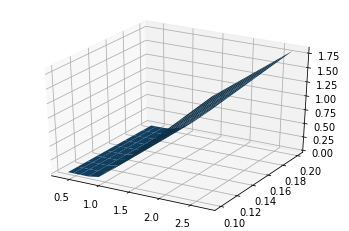

In [11]:
%matplotlib inline  
print('Plotting Black-Scholes solution:')
fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=spot_price_grid, Y=volatility_grid, Z=option_price_plot)

In [12]:
# Prediction:
dimension_each_feature = (number_samples_points_plot**2, 1)
option_parameters_plot = np.concatenate([
    spot_price_grid.reshape(-1,1), time_to_maturity_fixed*np.ones(dimension_each_feature),
    risk_free_rate_fixed*np.ones(dimension_each_feature), 
    volatility_grid.reshape(-1,1), strike_price_fixed*np.ones(dimension_each_feature)], axis=1)
X_plot = scale.transform(option_parameters_plot)

option_price_dnn = model.predict(X_plot)


Plotting DNN solution:


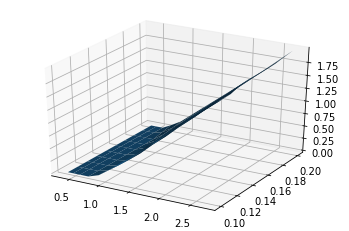

In [13]:
%matplotlib inline  
print('Plotting DNN solution:')

fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=spot_price_grid, Y=volatility_grid, 
                Z=option_price_dnn.reshape(number_samples_points_plot,number_samples_points_plot))

Plotting Difference of DNN to BS:


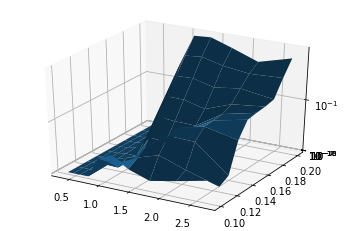

In [14]:
%matplotlib inline  

print('Plotting Difference of DNN to BS:')
fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=spot_price_grid, Y=volatility_grid, 
                Z=np.abs(option_price_plot - option_price_dnn.reshape(number_samples_points_plot,number_samples_points_plot)))
ax.set_zscale('log')